In [123]:
import ast
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

audio_df = pd.read_csv(
    '../data/files/audio_classification_5sec_deep_32.csv',
    converters={2: ast.literal_eval}
)

audio_df = audio_df.set_axis(['clip_id', 'genre', 'features', 'isAugmented'], axis=1)

records = []
for _, row in audio_df.iterrows():
    clip = row['clip_id']
    is_aug = row['isAugmented']
    genre  = row['genre']
    for seg_id, feat_vec in enumerate(row['features']):
        rec = {
            'clip_id':     clip,
            'isAugmented': is_aug,
            'segment_id':  seg_id,
            'genre':       genre
        }
        # flatten the vector
        for i, v in enumerate(feat_vec):
            rec[f'feat_{i}'] = v
        records.append(rec)

seg_df = pd.DataFrame(records)
le = LabelEncoder()
seg_df['genre_idx'] = le.fit_transform(seg_df['genre'])

train_clips, test_clips = train_test_split(
    audio_df, test_size=0.2, random_state=42,
    stratify=audio_df['genre'], shuffle=True
)
train_df = seg_df[seg_df.clip_id.isin(train_clips['clip_id'])]                       # real + augmented
test_df  = seg_df[seg_df.clip_id.isin(test_clips['clip_id']) & (seg_df.isAugmented==0)]
test_df_extra = seg_df[seg_df.clip_id.isin(test_clips['clip_id']) & (seg_df.isAugmented==1)]

train_df = pd.concat([train_df, test_df_extra])

# 5) PREPARE X / y
feature_cols = [c for c in seg_df.columns if c.startswith('feat_')] + ['isAugmented']
X_train = train_df[feature_cols]
y_train = train_df['genre_idx']
X_test  = test_df[feature_cols]
y_test_segments = test_df['genre_idx']

scaler = MaxAbsScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6) TRAIN XGBoost
clf = xgb.XGBClassifier(
    objective='multi:softmax',
    n_estimators=3000,
    learning_rate=0.25,
    max_depth=3,
    booster="gbtree",
    random_state=1122,
    eval_metric='mlogloss',
    device='cuda',
    n_jobs=-1
)
clf.fit(X_train, y_train, verbose=1)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3000, n_jobs=-1,
              num_parallel_tree=None, ...)

In [124]:
# 7) PREDICT segments & majority‐vote per clip
test_df = test_df.assign(pred_seg=clf.predict(X_test))
clip_preds = {
    cid: Counter(grp['pred_seg']).most_common(1)[0][0]
    for cid, grp in test_df.groupby('clip_id')
}

clip_summary = (
    test_df
    .groupby('clip_id')
    .agg(
       true = ('genre_idx', 'first'),
       pred = ('pred_seg', lambda x: Counter(x).most_common(1)[0][0])
    )
)

from sklearn.metrics import accuracy_score
print("file-level acc:", accuracy_score(clip_summary['true'], clip_summary['pred']))

y_true = test_df['genre_idx'].tolist()
print("clip-level acc:", accuracy_score(test_df['pred_seg'], y_true))

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Multiclass Confusion Matrix')
    plt.show()

file-level acc: 0.9312169312169312
clip-level acc: 0.8880070546737213


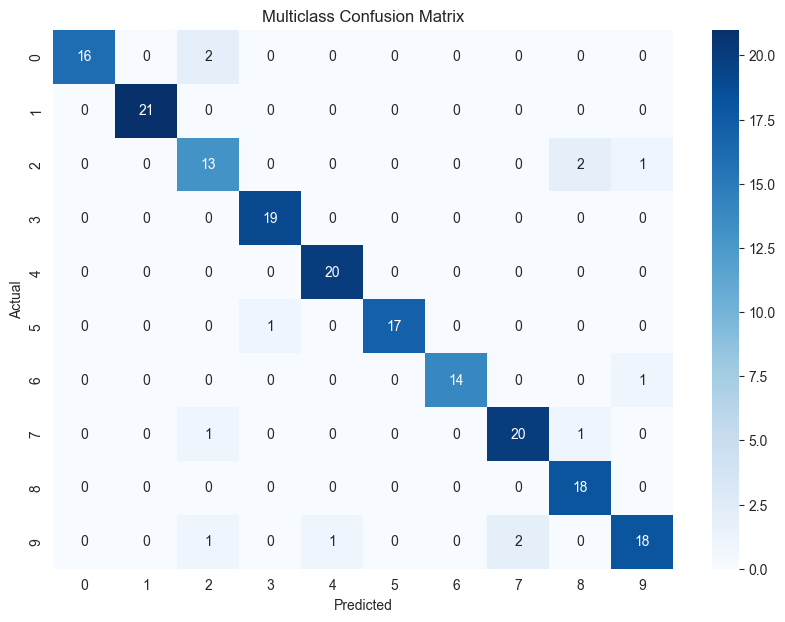

In [125]:
plot_confusion_matrix(clip_summary['pred'], clip_summary['true'], labels=y_test_segments.unique())

In [126]:
print(classification_report(y_true=clip_summary['true'], y_pred=clip_summary['pred']))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       1.00      1.00      1.00        21
           2       0.81      0.76      0.79        17
           3       1.00      0.95      0.97        20
           4       1.00      0.95      0.98        21
           5       0.94      1.00      0.97        17
           6       0.93      1.00      0.97        14
           7       0.91      0.91      0.91        22
           8       1.00      0.86      0.92        21
           9       0.82      0.90      0.86        20

    accuracy                           0.93       189
   macro avg       0.93      0.93      0.93       189
weighted avg       0.93      0.93      0.93       189



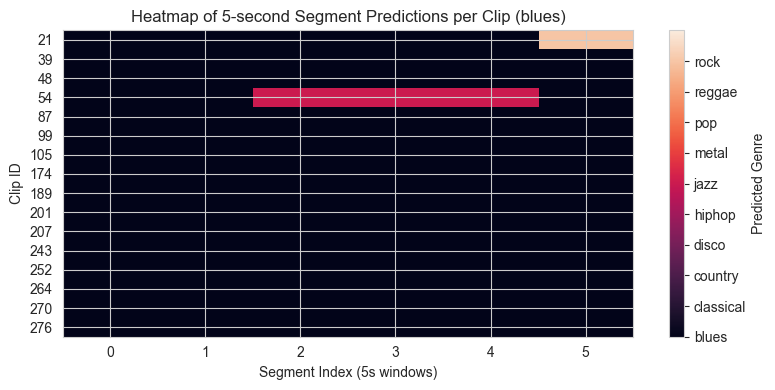

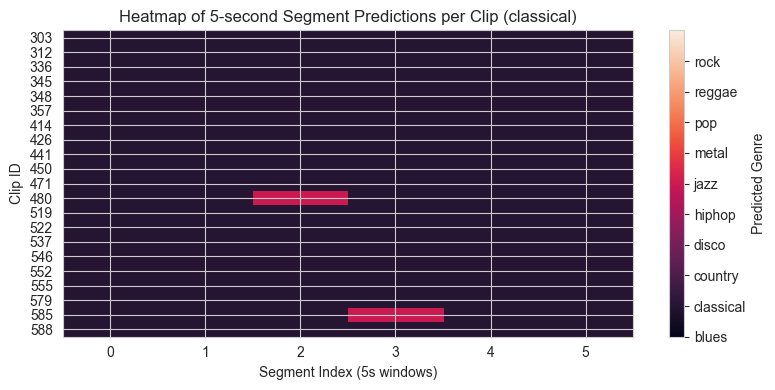

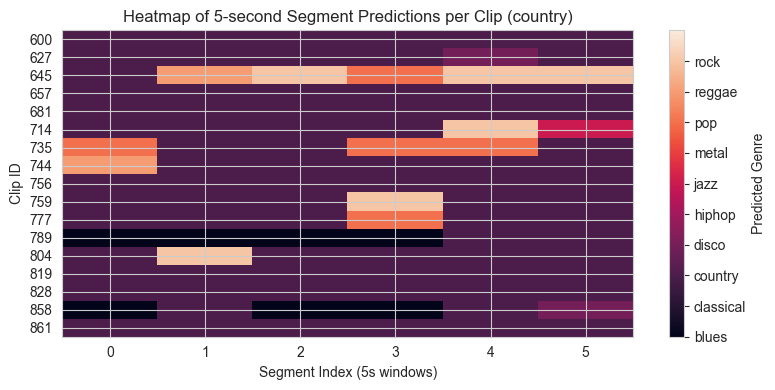

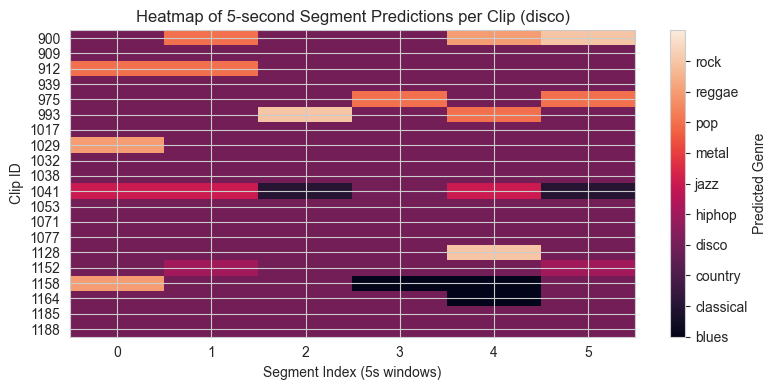

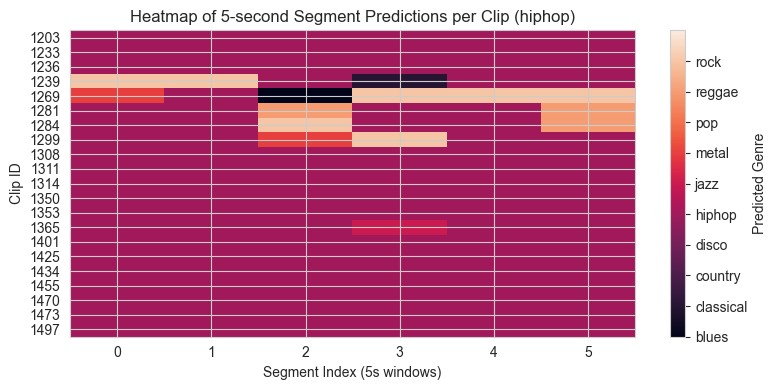

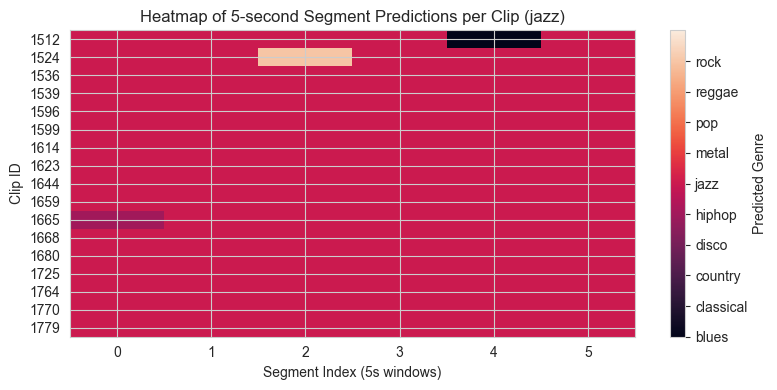

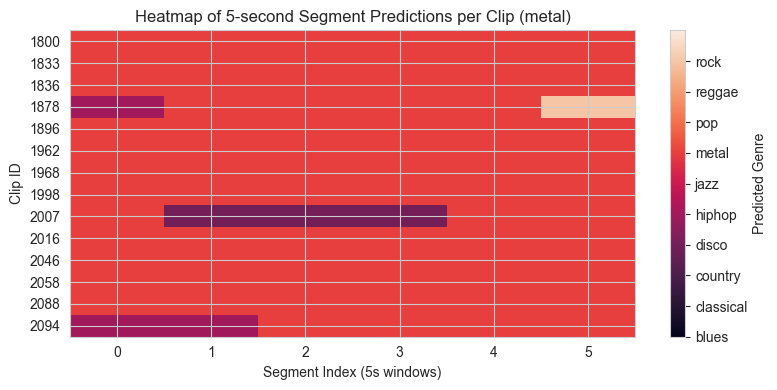

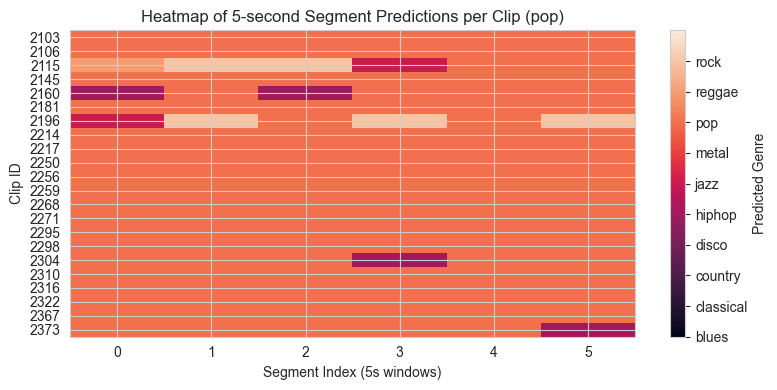

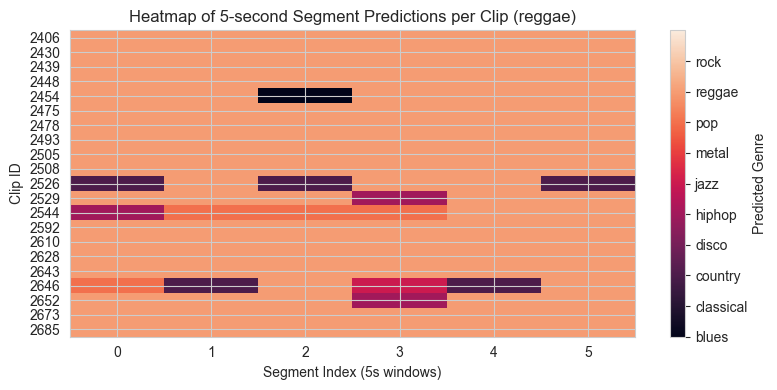

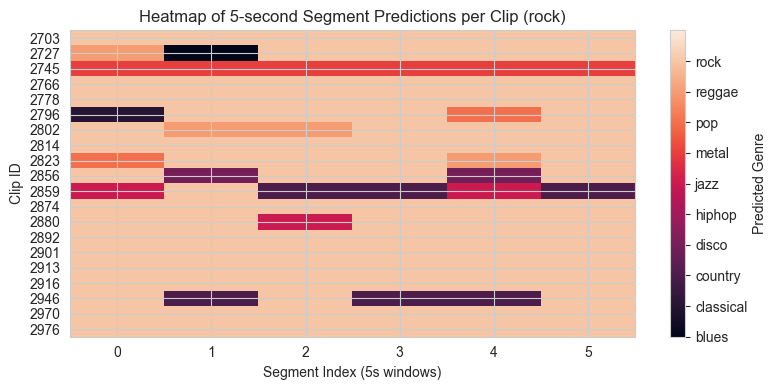

In [148]:
import matplotlib.pyplot as plt
import numpy as np


for i in range(0, 10):
    # Pivot using test_df if that's your DataFrame
    pivot = (
        test_df[test_df['genre_idx']==i]
        .pivot(index='clip_id', columns='segment_id', values='pred_seg')
        .sort_index()
        .sort_index(axis=1)
    )
    
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.imshow(pivot.values, aspect='auto', vmin=0, vmax=10)
    
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)
    
    label = le.inverse_transform([i])
    
    ax.set_xlabel('Segment Index (5s windows)')
    ax.set_ylabel('Clip ID')
    ax.set_title(f'Heatmap of 5-second Segment Predictions per Clip ({label[0]})')
    
        # ── Option A: show *all* genre names on the colorbar ─────────────────────
    cbar = fig.colorbar(im, ax=ax, ticks=np.arange(10))
    cbar.ax.set_yticklabels(le.inverse_transform(np.arange(10)))
    cbar.set_label('Predicted Genre')
    
    plt.tight_layout()
    plt.show()